The goal here is to calculate the zero-temperature Parisi constant for a pure p-spin glass.

Wei-Kuo Chen says:
> I am not aware of numerical simulations for the Parisi constant P(K) for large K. Nevertheless, this constant can be written as the Parisi formula, which is a convex optimization problem (see Theorem 1 in https://arxiv.org/pdf/1606.05335.pdf). With this, it should be fairly easy to run a numerical simulation to approximate P(K) for large K.


Paraphrased from the paper above:
> We introduce the space $U$ that collects all nonnegative and nondecreasing functions $f$ on $[0,1)$ that are right continuous and satisfy $\int_0^1 f(t)dt < \infty$. Let's say $f$ has $k$ jumps. Then it has value $m_i$ in region $[q_i,q_{i+1})$, given $q_0 = 0$ and $q_{k+1} = 1$, where $m_i$ and $q_i$ are increasing and nonnegative. The distance metric $d$ is the integral of $f$, or equivalently, $d = \sum_{i=1}^k m_i(q_{i+1} - q_i)$

$P(f) = \Psi_f(0, h) - 0.5 \int_0^1 t \xi^{''}(t)f(t) dt$

$\xi(s) =\sum_{p\ge 2} c_p^2 s^p$ Where the $c_p$'s are the mixing constants (mixed vs pure spin glasses).

$\partial_t \Psi_f(t,x) = -0.5\xi^{''}(t) 
\Big(
\partial_x^2 \Psi_f(t,x) + f(t) (\partial_x \Psi_f(t,x))^2
\Big)$

With boundary condition: $\Psi_f(1,x) = |x|$.

This can be solved recursively, by using the transformation $f(t) \Psi = \log \Phi$ for a piecewise, continuous function $f$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.optimize import minimize
from scipy import stats

This is the coefficient $a_{\ell} = \sqrt{ \xi^{'}(q_{\ell+1}) - \xi^{'}(q_{l}) }$

In [2]:
global k, xi, xiprime, xiprimeprime

In [3]:
def a(qs, l):
    return (xiprime(qs[l+1]) - xiprime(qs[l]))**0.5

Let $\Psi_{k+1}(x) = abs(x)$.

For $1\le \ell \le k$, let $Exp(m_{\ell} \Psi_{\ell}(x)) = \mathbb{E}[Exp(m_{\ell} \Psi_{\ell+1}(x + a_{\ell} z) ]$, for standard Gaussian variable $z$.

Let $\Psi_0(x) = \mathbb{E}[\Psi_{\ell+1}(x + a_{0} z)]$, since I let $m_0 = 0$.

In [4]:
def psi(qs, ms, l):
    offset = lambda x, z: psi(qs, ms, l+1)(x + a(qs, l)*z)
    if l == k+1:
        return lambda x: abs(x)
    elif l == 0:
        return Expectation(offset)
    else:
        return lambda v: 1/ms[l] * np.log(Expectation(lambda x, z: np.e**(ms[l]*offset(x,z)))(v))

This defines the expectation value.

In [5]:
INPS = np.linspace(-20,20, 40001)
PDF_INPS = stats.norm.pdf(INPS)/1000
assert np.allclose(sum(PDF_INPS),1), sum(PDF_INPS)

In [6]:
def Expectation(f):
    # f is function of x and z, where z is gaussian
    return lambda x: np.sum(f(x,INPS)*PDF_INPS)

The penalty term in the operator is $0.5 \int_0^1 f(t)  t \xi^{''}(t) dt = 0.5 \sum_{i=0}^k \int_{q_i}^{q_{i+1}} m_i t \xi^{''}(t) dt$

In [7]:
def penalty(qs, ms):
    out = 0
    for i in range(k+1):
        out += ms[i] * integrate.quad(lambda t: t * xiprimeprime(t), qs[i], qs[i+1])[0]
    return 0.5 * out

In [8]:
# the input here is a list of "adjustments" 
# (m_1, m_2-m_1, ...,m_k-m_{k-1}, q_1, q_2-q_1,...,q_k-q_{k-1})
def test(inp):
    assert len(inp) == 2*k
    inp_qs,inp_ms= inp[:k],inp[k:]

    # if bad input, return a large number
    if np.any(np.array(inp) < 0) or sum(inp_ms) > 1 or sum(inp_qs) > 1:
        return 10000

    qs = np.array([0,*[sum(inp_qs[:i+1]) for i in range(k)],1])
    ms = np.array([0,*[sum(inp_ms[:i+1]) for i in range(k)]])
    return psi(qs, ms, 0)(0) - penalty(qs, ms)

p: 2 1.0872961353105617
qs: [0, 5.489078671190992e-13, 1.7232329492556944e-12, 2.4376296526012215e-12, 1.0442652420226646e-11]
ms: [0, 0.3831134449896699, 0.3851366604290572, 0.3898946360385004, 0.5778687033343665]
p: 3 1.150512165277896
qs: [0, 3.137101350166459e-12, 6.449425397056191e-12, 9.121208386845529e-12, 1.7972811178462658e-11]
ms: [0, 0.8774486833216116, 0.9332019706229278, 0.943885109568558, 0.9783273618711826]
p: 4 1.1701342620231168
qs: [0, 1.4057213600070952e-11, 1.8711530711149064e-11, 2.7941432222785338e-11, 6.561722560947836e-11]
ms: [0, 0.8436341535967257, 0.9517577062955304, 0.972409432852583, 0.999999999998162]
p: 5 1.1803925191497284
qs: [0, 6.572008627934185e-09, 6.8059909345833794e-09, 7.0396208692402545e-09, 1.3658031048357912e-08]
ms: [0, 0.648759146923561, 0.7447620305331372, 0.7583955768662212, 0.999999999999863]
p: 6 1.1859685323390097
qs: [0, 9.402442406057413e-09, 2.296817356858426e-08, 1.1452602763664072e-07, 6.985855648722547e-07]
ms: [0, 0.7542456488422

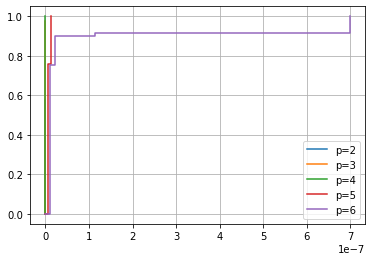

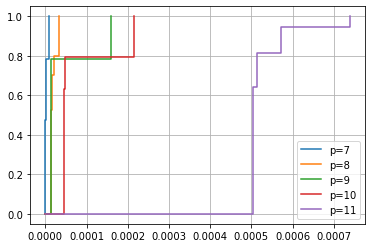

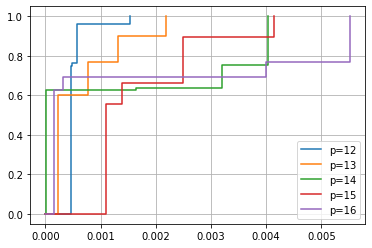

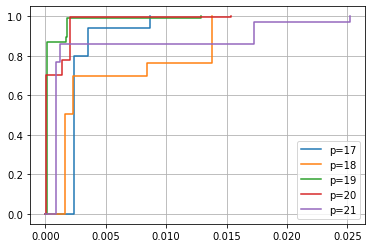

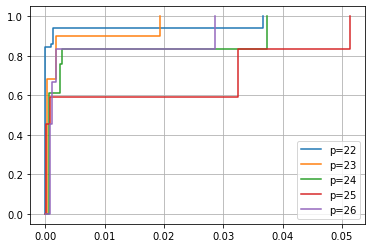

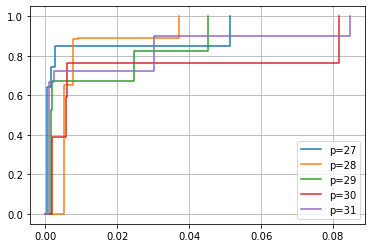

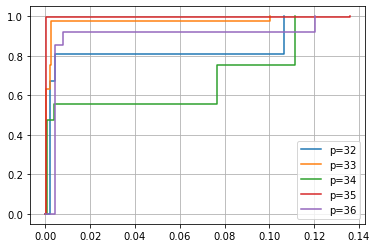

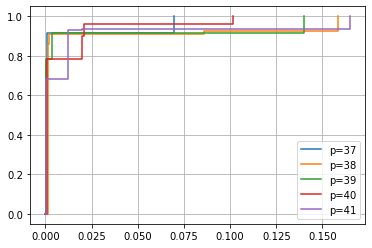

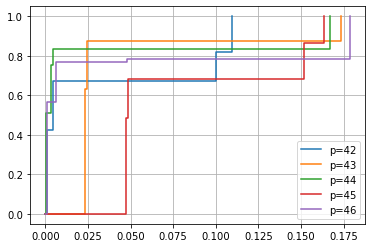

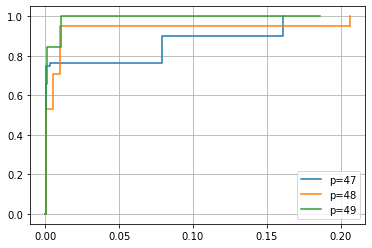

In [9]:
%%time

# pure p-spin model; p=2 is SK model
ps = range(2, 50)
# number of jumps
k=4

outs = []
for P in ps:
    if P % 5 == 2:
        plt.figure()
        plt.grid()
    # should xi be different by 1/2 ? I've seen it both ways.
    xi = lambda x: x**P
    xiprime = lambda x: P * (x**(P-1))
    xiprimeprime = lambda x: P * (P-1) * (x**(P-2))
    
    # find best function from minimizer
    best = None
    for _ in range(5):
        opt = minimize(test, [np.random.random()/k for _ in range(2*k)], method='Powell', options={"ftol":1e-14})
        if not best or best.fun > opt.fun:
            best = opt
    print("p:", P, best.fun)
    outs.append(best.fun)

    qs = list([0,*[sum(best.x[:k][:i+1]) for i in range(k)]])
    ms = list([0,*[sum(best.x[k:][:i+1]) for i in range(k)]])
    print("qs:", qs)
    print("ms:", ms)
#     qs = list(qs) + [1,]
#     ms = list(ms) + [list(ms)[-1],]
    plt.step(qs, ms, where='post', label="p=" + str(P))
    if P % 5 == 1:
        plt.legend()

plt.legend()
outs = np.array(outs)

These are the values of the constants:

In [10]:
for p, x in zip(ps, outs):
    print(p, x)

2 1.0872961353105617
3 1.150512165277896
4 1.1701342620231168
5 1.1803925191497284
6 1.1859685323390097
7 1.189063364670837
8 1.190805571920777
9 1.1917963694857976
10 1.1923641722520468
11 1.192691516871978
12 1.1928811421368621
13 1.1929914227618097
14 1.1930557709526148
15 1.19309342345547
16 1.1931155087719576
17 1.1931284904482906
18 1.193136135233308
19 1.1931406446051405
20 1.1931433084376621
21 1.193144884136494
22 1.193145817304309
23 1.1931463705511547
24 1.1931466988803123
25 1.1931468939079082
26 1.1931470098511152
27 1.19314707883216
28 1.193147119902104
29 1.1931471443715118
30 1.193147158957645
31 1.1931471676584824
32 1.1931471728513259
33 1.1931471759519567
34 1.1931471778043239
35 1.1931471789114987
36 1.1931471795739554
37 1.1931471799693476
38 1.1931471802062994
39 1.1931471803482658
40 1.1931471804329732
41 1.193147180483809
42 1.193147180514476
43 1.1931471805325877
44 1.193147180543523
45 1.1931471805500777
46 1.1931471805539609
47 1.1931471805564016
48 1.1931471

The numbers seem to converge -- is there an asymptotic value for large $p$? Perhaps $0.5 + ln(2) \approx 1.19314718055994$?


In [11]:
np.log(2) + 0.5

1.1931471805599454

I notice that the locations of the symmetry breaking points are often at very low values.  This may be related to the Auffinger Chen Zeng result that perturbing a solution to this variational near $1$ will reduce the energy. So perhaps perturbations very close to $0$ can also reduce the energy: https://sci-hubtw.hkvisa.net/10.1002/cpa.21886

I insert these values for Subrabhata Sen's bounds for MAX XOR on hypergraphs, as listed here: https://sci-hubtw.hkvisa.net/10.1002/rsa.20774

The satisfying fraction for MAX CUT on p-uniform hypergraphs is to first order in D: $\frac{1}{2}+ \frac{P_p \sqrt{p}}{2}\frac{1}{\sqrt{D}}$

This makes the satisfying fraction $\frac{1}{2} + \frac{C_p}{\sqrt{D}}$, where $C_p$ is listed below:

In [12]:
for p, x in zip(ps, outs):
    print(p, x*p**0.5 / 2)

2 0.7688344704360242
3 0.9963727624936987
4 1.1701342620231168
5 1.3197189564755076
6 1.4525088776140118
7 1.5729829780083704
8 1.6840533899598131
9 1.7876945542286964
10 1.8852932923489047
11 1.977855126052094
12 2.0661307455718365
13 2.150695872978221
14 2.2320029691090655
15 2.3104154797563146
16 2.386231017543915
17 2.4596973955260273
18 2.531023956306545
19 2.6003897476323927
20 2.667949544565611
21 2.7338383733023996
22 2.7981749726257688
23 2.861064487907693
24 2.922600600542934
25 2.9828672347697704
26 3.0419399429078595
27 3.099887042159535
28 3.156770556773932
29 3.212647005801248
30 3.2675680669215215
31 3.3215811398502377
32 3.3747298275069215
33 3.4270543493979737
34 3.4785918986237228
35 3.529376951710329
36 3.5794415387218663
37 3.628815479724267
38 3.6775265926333303
39 3.7256008765348065
40 3.773062673976082
41 3.819934815090271
42 3.866238745975377
43 3.9119946433933523
44 3.957221517533298
45 4.001937304308283
46 4.046158948476253
47 4.089902478668515
48 4.1331830752

The agreement $C_2 \approx P_* \approx 0.76$ gives me confidence that this approach is correct.

What do you think?